<a href="https://colab.research.google.com/github/wenqiglantz/hands-on-llamaindex/blob/main/04_finetune_llm_gpt_3_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NVIDIA SEC 10-K Filing, Fine-Tuning gpt-3.5-turbo

Fine-tuning enables `gpt-3.5-turbo` to be fine-tuned on `gpt-4` training data and output better responses.

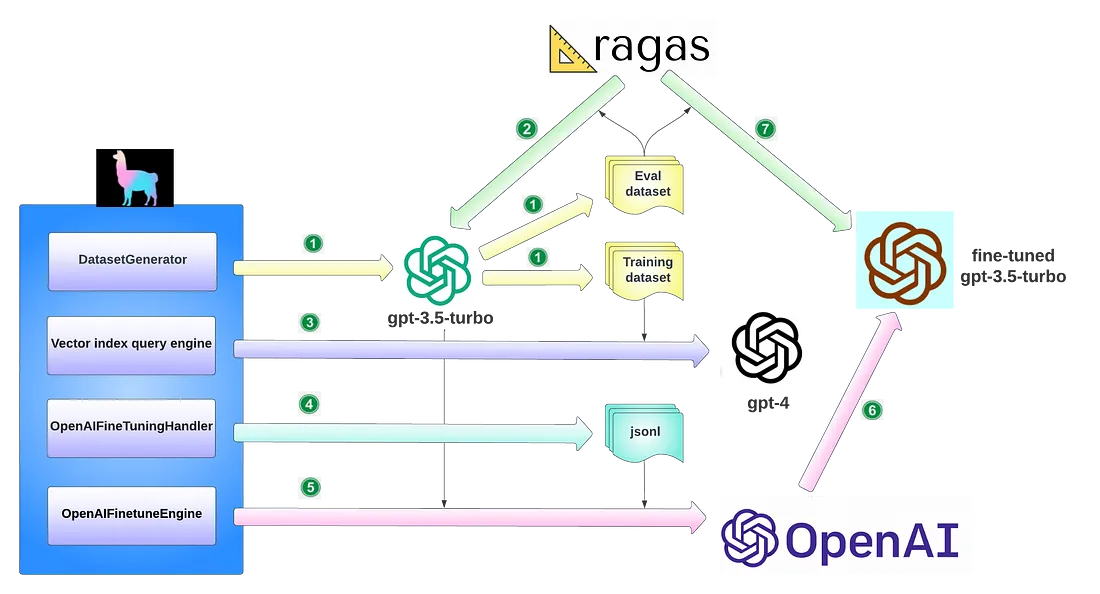

Detailed steps:

1. Data generation automation for both eval dataset and training dataset, using `DatasetGenerator`.
2. Eval for base model gpt-3.5-turbo before fine-tuning, using the eval dataset generated from step 1.
3. Construct vector index query engine and call gpt-4 to collect training data based on the training dataset.
4. Callback handler `OpenAIFineTuningHandler` collects all messages sent to gpt-4, along with their responses, saves these messages in a `.jsonl` (JSON-line) format that can be consumed by OpenAI API endpoint for fine-tuning.
5. `OpenAIFinetuneEngine` is constructed by passing in gpt-3.5-turbo and the jsonl file generated from step 4, it sends a finetune call to OpenAI, launching a fine-tuning job request to OpenAI.
6. OpenAI creates the fine-tuned gpt-3.5-turbo model as per your request.
7. Eval for fine-tuned model by using the eval dataset generated from step 1.



## Installation, download and load document

In [1]:
%pip install -q llama-index-llms-openai
%pip install -q llama-index-finetuning
%pip install -q llama-index-finetuning-callbacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.0/631.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -q llama_index pypdf sentence-transformers ragas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.9/815.9 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [3]:
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    Response
)
from llama_index.core.evaluation import (
    DatasetGenerator,
    QueryResponseEvaluator,
    ResponseEvaluator
)
from llama_index.llms.openai import OpenAI
import pandas as pd
import openai
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
from google.colab import userdata
import logging, sys
import nest_asyncio
from langchain.embeddings.openai import OpenAIEmbeddings

nest_asyncio.apply()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

# set OpenAI API key in environment variable
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

#define LLM
llm_gpt35 = OpenAI(temperature=0, model_name="gpt-3.5-turbo")
embed_model = OpenAIEmbeddings(model_name="text-embedding-ada-002")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_community/embeddings/openai.py:268: UserWarning: WARNING! model_name is not default parameter.
                    model_name was transferred to model_kwargs.
                    Please confirm that model_name is what you intended.
  warnings.warn(


In [5]:
!curl https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/4e9abe7b-fdc7-4cd2-8487-dc3a99f30e98.pdf --output nvidia-sec-10k-2022.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1541k  100 1541k    0     0  2600k      0 --:--:-- --:--:-- --:--:-- 2598k


In [6]:
# Shuffle the documents
import random

# load documents
documents = SimpleDirectoryReader(input_files=["nvidia-sec-10k-2022.pdf"]).load_data()
print(f"loaded documents with {len(documents)} pages")

random.seed(42)
random.shuffle(documents)

loaded documents with 169 pages


## Generate datasets

Let's first generate two datasets, one for training, the other for eval

### Training dataset

In [7]:
import random
random.seed(42)

questions = []
if os.path.exists("train_questions.txt"):
    with open("train_questions.txt", "r") as f:
        for line in f:
            questions.append(line.strip())
else:
    question_gen_query = (
        "You are a Teacher/ Professor. Your task is to setup "
        "a quiz/examination. Using the provided context from the NVIDIA SEC 10-K filing, formulate "
        "a single question that captures an important fact from the context. "
        "context. Restrict the question to the context information provided."
    )
    # generate questions
    dataset_generator = DatasetGenerator.from_documents(
        documents[:50],
        question_gen_query=question_gen_query,
        llm=llm_gpt35,
    )

    questions = dataset_generator.generate_questions_from_nodes(num=40)
    print(f"Generated {len(questions)} questions.")

    # save the questions!
    with open("train_questions.txt", "w") as f:
        for question in questions:
            f.write(f"{question.strip()}\n")

/usr/local/lib/python3.10/dist-packages/llama_index/core/evaluation/dataset_generation.py:212: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be used instead.)
  return cls(


Generated 40 questions.


/usr/local/lib/python3.10/dist-packages/llama_index/core/evaluation/dataset_generation.py:309: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return QueryResponseDataset(queries=queries, responses=responses_dict)


In [8]:
for i, question in enumerate(questions, start=1):
    print(f"{i}. {question}")

1. What potential risks does NVIDIA face in terms of supply chain management and demand forecasting according to the information provided in the SEC 10-K filing?
2. What is the definition of a "Restricted Stock Unit Award" according to the NVIDIA Corporation Amended and Restated 2007 Equity Incentive Plan?
3. What is the minimum percentage that the exercise price of an Incentive Stock Option granted to a Ten Percent Stockholder must be above the Fair Market Value on the date of grant?
4. What was the total comprehensive income for NVIDIA Corporation and its subsidiaries for the year ended January 29, 2023?
5. What was the total amount of deferred revenue added during fiscal year 2023 according to the NVIDIA SEC 10-K filing?
6. What restrictions are placed on the transfer of shares of Common Stock acquired under the Plan according to the information provided in the NVIDIA SEC 10-K filing?
7. What steps can participants in the Plan take if they wish to view their data, request additional

### Eval dataset

Notice we are not overlapping the training questions with eval questions by starting from doc 50 and beyond. It's generally good ML practice. If we finetune a model over an existing set of questions, it will do well over that specific set of questions. But we want to test that it can generalize to other questions too (e.g. for production load), so we create an evaluation set with a separate set of questions.

In [9]:
questions = []
if os.path.exists("eval_questions.txt"):
    with open("eval_questions.txt", "r") as f:
        for line in f:
            questions.append(line.strip())
else:
    dataset_generator = DatasetGenerator.from_documents(
        documents[
            50:
        ],  # since we don't want to overlap training questions, we can skip the first 50
        question_gen_query=question_gen_query,
        llm=llm_gpt35,
    )

    questions = dataset_generator.generate_questions_from_nodes(num=40)
    print(f"Generated {len(questions)} questions.")

    # save the questions!
    with open("eval_questions.txt", "w") as f:
        for question in questions:
            f.write(f"{question.strip()}\n")

/usr/local/lib/python3.10/dist-packages/llama_index/core/evaluation/dataset_generation.py:212: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be used instead.)
  return cls(


Generated 40 questions.


/usr/local/lib/python3.10/dist-packages/llama_index/core/evaluation/dataset_generation.py:309: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return QueryResponseDataset(queries=queries, responses=responses_dict)


In [10]:
    for i, question in enumerate(questions, start=1):
        print(f"{i}. {question}")

1. What method does NVIDIA use to compute diluted net income per share, and why are equity awards not included in the computation for periods when their effect is anti-dilutive?
2. What are the requirements for Thai residents who realize US$1,000,000 or more in a single transaction from the sale of shares of Common Stock or the payment of dividends?
3. What conditions must be met for a Restricted Stock Unit Award to become fully vested in the event of a Participant's termination of Continuous Service due to death?
4. What regulations may subject the recipient of the Award to insider trading restrictions and market abuse laws?
5. What are the methods outlined in the NVIDIA SEC 10-K filing for satisfying withholding obligations for Tax-Related Items in relation to Restricted Stock Units?
6. What is the purpose of the Compliance with Section 409A of the Code in relation to the Award mentioned in the agreement?
7. What are some key factors that could potentially impact NVIDIA's financial r

## Baseline eval for gpt-3.5-turbo

Let's evaluate our base model with both ragas framework and evaluation module (optional).


### Eval with ragas

We will be using the following two metrics:

- `answer_relevancy` - This measures how relevant is the generated answer to the prompt. If the generated answer is incomplete or contains redundant information the score will be low. This is quantified by working out the chance of an LLM generating the given question using the generated answer. Values range (0,1), higher the better.

- `faithfulness` - This measures the factual consistency of the generated answer against the given context. This is done using a multi step paradigm that includes creation of statements from the generated answer followed by verifying each of these statements against the context. The answer is scaled to (0,1) range. Higher the better.

In [11]:
questions = []
with open("eval_questions.txt", "r") as f:
    for line in f:
        questions.append(line.strip())

# limit the context window to 2048 tokens so that refine is used
from llama_index.core import Settings

Settings.context_window = 2048

# build vector index and query engine
index = VectorStoreIndex.from_documents(documents)
query_engine = index.as_query_engine(similarity_top_k=2, llm=llm_gpt35)


In [12]:
contexts = []
answers = []

for question in questions:
    response = query_engine.query(question)
    contexts.append([x.node.get_content() for x in response.source_nodes])
    answers.append(str(response))

In [13]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import answer_relevancy, faithfulness

ds = Dataset.from_dict(
    {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
    }
)

result = evaluate(ds, [answer_relevancy, faithfulness])
print(result)

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/ragas/executor.py", line 75, in run
    results = self.loop.run_until_complete(self._aresults())
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 98, in run_until_complete
    return f.result()
  File "/usr/lib/python3.10/asyncio/futures.py", line 201, in result
    raise self._exception.with_traceback(self._exception_tb)
  File "/usr/lib/python3.10/asyncio/tasks.py", line 232, in __step
    result = coro.send(None)
  File "/usr/local/lib/python3.10/dist-packages/ragas/executor.py", line 63, in _aresults
    raise e
  File "/usr/local/lib/python3.10/dist-packages/ragas/executor.py", line 58, in _aresults
    r = await future
  File "/usr/lib/python3.10/asyncio/tasks.py", line 571, in _wait_for_one
    return f.result()  # May raise f.exception().
  File "/usr/lib/p

ExceptionInRunner: The runner thread which was running the jobs raised an exeception. Read the traceback above to debug it. You can also pass `raise_exception=False` incase you want to show only a warning message instead.

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', 200)
result.to_pandas()

### Eval with evaluation module


In [ ]:
import time
import asyncio
import nest_asyncio
nest_asyncio.apply()

def evaluate_query_engine(evaluator, query_engine, questions):
    async def run_query(query_engine, q):
        try:
            return await query_engine.aquery(q)
        except:
            return Response(response="Error, query failed.")

    total_correct = 0
    all_results = []
    for batch_size in range(0, len(questions), 5):
        batch_qs = questions[batch_size:batch_size+5]

        tasks = [run_query(query_engine, q) for q in batch_qs]
        responses = asyncio.run(asyncio.gather(*tasks))
        print(f"finished batch {(batch_size // 5) + 1} out of {len(questions) // 5}")

        # eval for hallucination
        if isinstance(evaluator, ResponseEvaluator):
          for response in responses:
              eval_result = 1 if "YES" in evaluator.evaluate(response) else 0
              total_correct += eval_result
              all_results.append(eval_result)
        # eval for answer quality
        elif isinstance(evaluator, QueryResponseEvaluator):
          for question, response in zip(batch_qs, responses):
              eval_result = 1 if "YES" in evaluator.evaluate(question, response) else 0
              total_correct += eval_result
              all_results.append(eval_result)

        # helps avoid rate limits
        time.sleep(1)

    return total_correct, all_results

In [ ]:
# use gpt-4 to evaluate
llm_gpt4=OpenAI(temperature=0, llm="gpt-4")

questions = []
with open("eval_questions.txt", "r") as f:
    for line in f:
        questions.append(line.strip())

In [ ]:
# eval for hallucination
evaluator = ResponseEvaluator(llm=llm_gpt4)
total_correct, all_results = evaluate_query_engine(evaluator, query_engine, questions)
print(f"Hallucination? Scored {total_correct} out of {len(questions)} questions correctly.")

In [ ]:
# eval for answer quality
evaluator = QueryResponseEvaluator(llm=llm_gpt4)
total_correct, all_results = evaluate_query_engine(evaluator, query_engine, questions)
print(f"Response satisfies the query? Scored {total_correct} out of {len(questions)} questions correctly.")

## GPT4 to collect training data

In [ ]:
from llama_index.llms.openai import OpenAI
from llama_index.finetuning.callbacks import OpenAIFineTuningHandler
from llama_index.finetuning.callbacks import CallbackManager

finetuning_handler = OpenAIFineTuningHandler()
callback_manager = CallbackManager([finetuning_handler])

In [ ]:
questions = []
with open("train_questions.txt", "r") as f:
    for line in f:
        questions.append(line.strip())

In [ ]:
index = VectorStoreIndex.from_documents(documents)
query_engine = index.as_query_engine(similarity_top_k=2, llm=llm_gpt4)

for question in questions:
    response = query_engine.query(question)

In [ ]:
finetuning_handler.save_finetuning_events("finetuning_events.jsonl")

## Create OpenAIFinetuneEngine

In [ ]:
from llama_index.finetuning import OpenAIFinetuneEngine

finetune_engine = OpenAIFinetuneEngine(
    "gpt-3.5-turbo",
    "finetuning_events.jsonl"
)

In [ ]:
finetune_engine.finetune()

In [ ]:
finetune_engine.get_current_job()

Need to wait a few minutes here till the fine-tuning job completes successfully at OpenAI, then an email will be sent out from OpenAI letting you know your fine-tuned model is ready to be used.

In [ ]:
ft_llm = finetune_engine.get_finetuned_model(temperature=0.3)

## Evaluation for fine-tuned model

### Eval with ragas

In [ ]:
from llama_index.llm.openai import OpenAI
from llama_index.finetuning.callbacks import OpenAIFineTuningHandler
from llama_index.finetuning.callbacks import CallbackManager

questions = []
with open("eval_questions.txt", "r") as f:
    for line in f:
        questions.append(line.strip())

In [ ]:
index = VectorStoreIndex.from_documents(documents)

query_engine = index.as_query_engine(similarity_top_k=2, llm=ft_llm)

In [ ]:
contexts = []
answers = []

for question in questions:
    response = query_engine.query(question)
    contexts.append([x.node.get_content() for x in response.source_nodes])
    answers.append(str(response))

In [ ]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import answer_relevancy, faithfulness

ds = Dataset.from_dict(
    {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
    }
)

result = evaluate(ds, [answer_relevancy, faithfulness])
print(result)

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', 200)
result.to_pandas()

### Eval with evaluation module

In [ ]:
# eval for hallucination
evaluator = ResponseEvaluator(llm=llm_gpt4)
total_correct, all_results = evaluate_query_engine(evaluator, query_engine, questions)
print(f"Hallucination? Scored {total_correct} out of {len(questions)} questions correctly.")

In [ ]:
# eval for answer quality
evaluator = QueryResponseEvaluator(llm=llm_gpt4)
total_correct, all_results = evaluate_query_engine(evaluator, query_engine, questions)
print(f"Response satisfies the query? Scored {total_correct} out of {len(questions)} questions correctly.")

## Exploring difference

In [ ]:
index = VectorStoreIndex.from_documents(documents)

In [ ]:
questions = []
with open("eval_questions.txt", "r") as f:
    for line in f:
        questions.append(line.strip())

In [ ]:
print(questions[0])

### Baseline model

In [ ]:
from llama_index.response.notebook_utils import display_response

query_engine = index.as_query_engine(llm=llm_gpt35)

response = query_engine.query(questions[0])

display_response(response)

### Fine-tuned model

In [ ]:
query_engine = index.as_query_engine(llm=ft_llm)

response = query_engine.query(questions[0])

display_response(response)